In [57]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
import poppy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi

import scoobpsf.scoob_rmad as rmad

import lina
import lina.utils as utils
print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()
from magpyx.fdpr2 import console, tools

dm_beam_diam = 9.2e-3
lyot_diam = 8.6e-3
wavelength = 633e-9

/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [58]:
date = 20241028
fit_ref = utils.load_pickle(f'data/{date}_fdpr2_fit_ref.pkl')
fit_reg = utils.load_pickle(f'data/{date}_fdpr2_fit_reg.pkl')

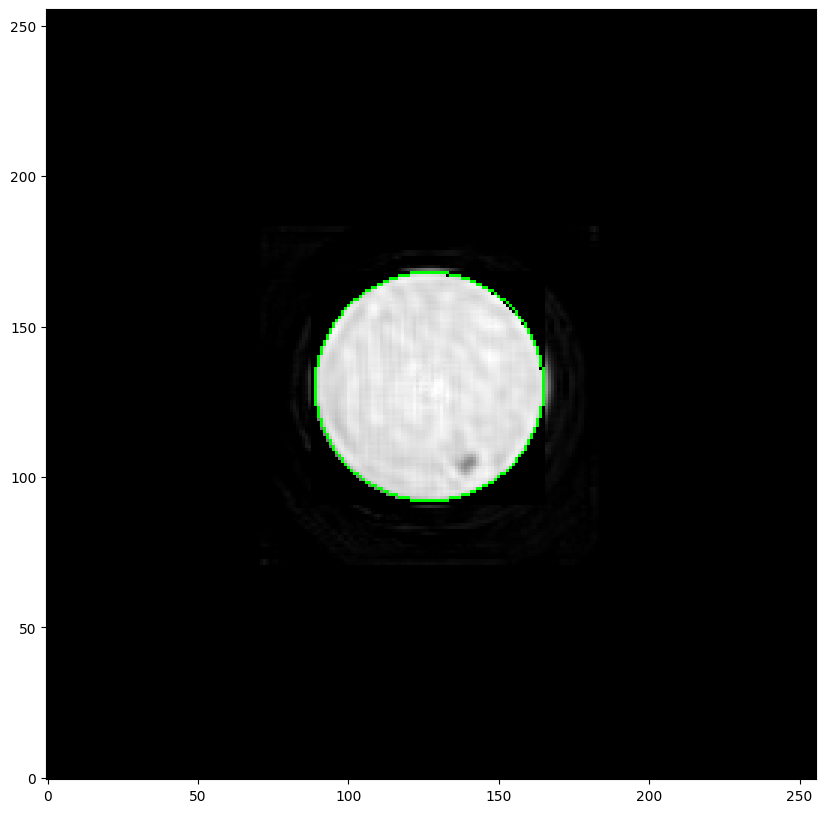

In [75]:
# Load picture and detect edges
image = img_as_ubyte(fit_ref['amp_est']/np.max(fit_ref['amp_est']))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=100)

# Detect two radii
hough_radii = np.arange(30, 45, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

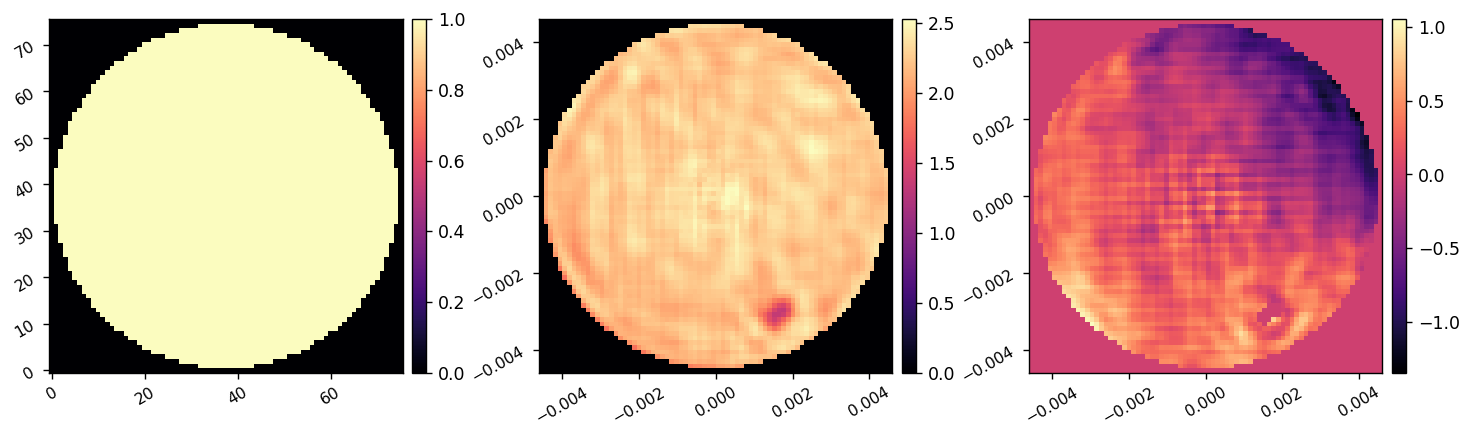

In [77]:
amp_est_ref = fit_ref['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_ref = fit_ref['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
Nfit = amp_est_ref.shape[0]
y,x = (np.indices((Nfit, Nfit)) - Nfit/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(radii[0]-1)

amp_est_ref *= fit_mask
phs_est_ref *= fit_mask
pr_pxscl = dm_beam_diam/(2*radii[0])
imshow3(fit_mask, amp_est_ref, phs_est_ref, pxscl2=pr_pxscl, pxscl3=pr_pxscl)


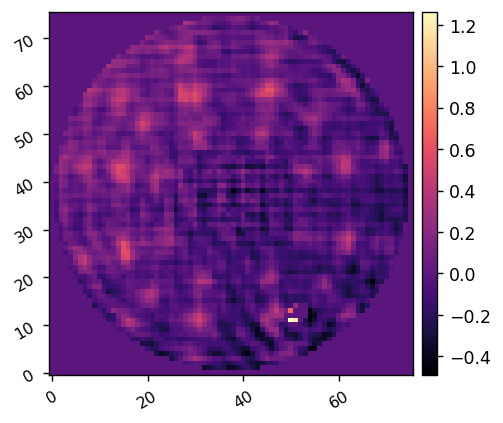

In [86]:
phs_est_reg = fit_reg['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est_reg *= fit_mask

del_phs_reg = xp.array(phs_est_reg - phs_est_ref)
imshow1(del_phs_reg)

In [87]:
reload(rmad)
M = rmad.MODEL()
M.WFE = xp.array(utils.load_pickle('data/processed_pr_wfe.fits'))

M.flip_dm = 1
M.flip_lyot_ud = 1

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

fpwf, Epup, dm_phasor = M.forward(fit_reg['command'][M.dm_mask], use_vortex=True, return_ints=True)
m_dm_phs = xp.angle(utils.pad_or_crop(dm_phasor, M.npix))
# imshow2( lognorm1=True)

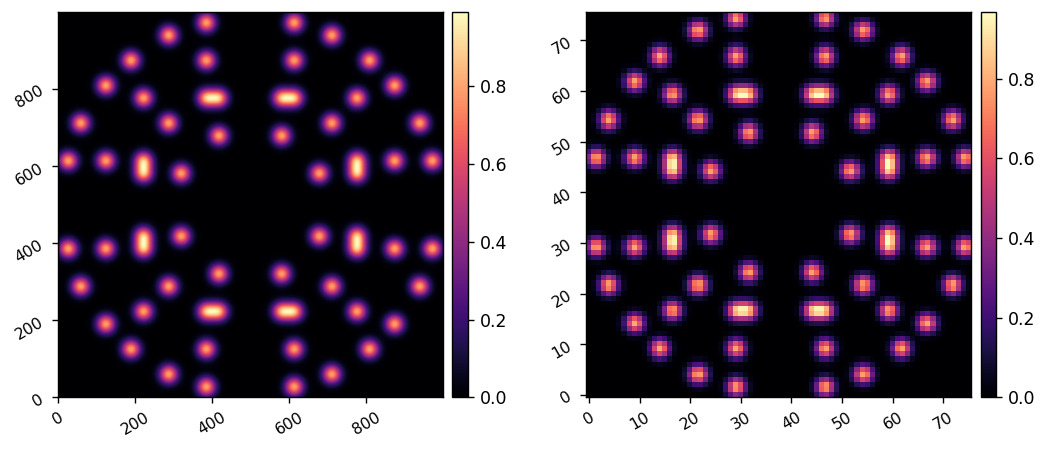

In [88]:
reload(utils)
i_m_dm_phs = utils.interp_arr(m_dm_phs, M.dm_pxscl, pr_pxscl, order=5)
i_m_dm_phs = utils.pad_or_crop(i_m_dm_phs, fit_mask.shape[0])
imshow2(m_dm_phs, i_m_dm_phs)

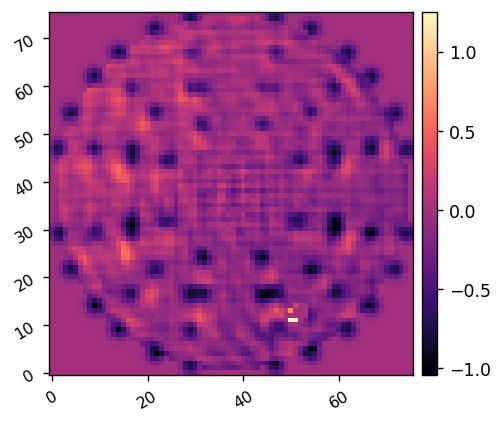

In [89]:
imshow1(del_phs_reg - i_m_dm_phs)